In [8]:
import os
import pandas
import cv2
import numpy 




In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy 
import pickle
import os


In [17]:
class selective_tracker():

    data = pandas.read_csv('/Users/akshitshishodia/intern/tracker/labels_my-project-name_2023-06-27-09-45-54.csv')
    pos = 0
    neg = 0
    def __init__(self) -> None:
        pass
    def calculate_iou(box_a,box_b):
        xA = max(box_a[0],box_b[0])
        yA = max(box_a[1],box_b[1])
        xB = min(box_a[2],box_b[2])
        yB = min(box_a[3],box_b[3])
        inter_area = max(0, xB - xA + 1) * max(0, yB - yA + 1)
        pred = (box_a[2]-box_a[0]+1)*(box_a[3]-box_a[1]+1)
        ground_truth = (box_b[2]-box_b[0]+1)*(box_b[3]-box_b[1]+1)
        iou = inter_area / float(pred + ground_truth - inter_area)
        return iou
    
    @classmethod
    def annotation_extracter(cls,path):
        totalpos = 0
        totalneg = 0
        image_path = [file for file in os.listdir(path=path)]
        gt_box = list()
        for image_loc in image_path:
            row = cls.data[cls.data['image_name']== image_loc]
            w = int(row.image_width)
            h = int(row.image_height)
            x_min = int(row.bbox_x)
            y_min = int(row.bbox_y)
            x_max= int(row.bbox_x)+int(row.bbox_width)
            y_max = int(row.bbox_y)+int(row.bbox_height)

            x_min = max(0,x_min)
            y_min = max(0,y_min)
            x_max = min(w,x_max)
            y_max = min(h,y_max)

            gt_box.append((x_min,y_min,x_max,y_max))
            img = cv2.imread(os.path.join(path,image_loc))
            ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
            ss.setBaseImage(img)
            ss.switchToSelectiveSearchQuality()
            rects = ss.process()
            proposedRegions = list()
            for x,y,w,h in rects:
                pos_roi = 0
                neg_roi = 0
                proposedRegions.append((x,y,x+w,y+h))
                for proposedRect in proposedRegions[:2000]:
                    (x1,y1,x2,y2) = proposedRect
                    for gt in gt_box:
                        IOU = cls.calculate_iou(gt,proposedRect)
                        roi = None
                        OutputPath = None
                        (gx1,gy1,gx2,gy2) = gt

                        if IOU > 0.7 and cls.pos <= 2000:
                            roi = img[y1:y2,x1:x2]
                            loc = str(totalpos)+'.png'
                            OutputPath = os.path.join('/Users/akshitshishodia/intern/tracker/refined/good',loc)
                            totalpos+=1
                            cls.pos+=1                            
                        fullOverlap = x1 >= gx1
                        fullOverlap = fullOverlap and y1 >= gy1
                        fullOverlap = fullOverlap and x2 <= gx2
                        fullOverlap = fullOverlap and y2 <= gy2

                        if not fullOverlap and IOU < 0.1 and cls.neg<=2000:
                            roi = img[y1:y2,x1:x2]
                            loc = str(totalneg)+'.png'
                            OutputPath = os.path.join('/Users/akshitshishodia/intern/tracker/refined/bad',loc)
                            totalneg+=1
                            cls.neg+=1
                        
                        if roi is not None and OutputPath is not None:
                            roi = cv2.resize(roi,(224,224),cv2.INTER_CUBIC)
                            cv2.imwrite(OutputPath,roi)

    def build_model(self):
        EPOCHS = 5
        BS = 50
        LR = 1e-4
        data = list()
        labels = list()
        #gripper
        gripper_path = '/Users/akshitshishodia/intern/tracker/refined/gripper'
        for file in os.listdir(path=gripper_path):
            frame = cv2.imread(os.path.join(gripper_path,file))
            frame = img_to_array(frame)
            frame = preprocess_input(frame)
            data.append(frame)
            labels.append('gripper')
        not_gripper = '/Users/akshitshishodia/intern/tracker/refined/not gripper'
        for file in os.listdir(path=not_gripper):
            frame = cv2.imread(os.path.join(gripper_path,file))
            frame = img_to_array(frame)
            frame = preprocess_input(frame)
            data.append(frame)
            labels.append('not gripper')
        
        data = numpy.array(data,dtype=numpy.float32)
        labels = numpy.array(labels)

        lb = LabelBinarizer()
        labels = lb.fit_transform(labels)
        labels = to_categorical(labels)

        (trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

        augment = ImageDataGenerator(
            rotation_range=20,
            zoom_range=0.15,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.15,
            horizontal_flip=True,
            fill_mode="nearest"
        )

        base_model = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))
        headModel = base_model.output
        headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
        headModel = Flatten(name="flatten")(headModel)
        headModel = Dense(128, activation="relu")(headModel)
        headModel = Dropout(0.5)(headModel)
        headModel = Dense(2, activation="softmax")(headModel)

        model = Model(inputs=base_model.input, outputs=headModel)

        # for layer in base_model.layers():
        #     layer.trainable = False
        
        opt =  Adam(LR)
        model.compile(loss = 'binary_crossentropy',optimizer = opt,metrics = ['accuracy'])
        History = model.fit(
        augment.flow(trainX, trainY, batch_size=BS),
        steps_per_epoch=len(trainX) // BS,
        validation_data=(testX, testY),
        validation_steps=len(testX) // BS,
        epochs=EPOCHS)


        model.save('model_3.h5',save_format = 'h5')
        f = open('label_encoder.pickle', "wb")
        f.write(pickle.dumps(lb))
        f.close()
        return History,model

test_obj = selective_tracker()
history,model = test_obj.build_model()

Epoch 1/5
64/64 [==============================] - 162s 2s/step - loss: 0.7459 - accuracy: 0.4995 - val_loss: 0.7129 - val_accuracy: 0.4956
Epoch 2/5
64/64 [==============================] - 169s 3s/step - loss: 0.7042 - accuracy: 0.4935 - val_loss: 0.7074 - val_accuracy: 0.5006
Epoch 3/5
64/64 [==============================] - 174s 3s/step - loss: 0.7018 - accuracy: 0.4897 - val_loss: 0.7200 - val_accuracy: 0.5006
Epoch 4/5
64/64 [==============================] - 160s 2s/step - loss: 0.6974 - accuracy: 0.5024 - val_loss: 0.6998 - val_accuracy: 0.4906
Epoch 5/5
64/64 [==============================] - 167s 3s/step - loss: 0.6959 - accuracy: 0.5062 - val_loss: 0.6984 - val_accuracy: 0.5006


/Users/akshitshishodia/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


KeyError: "None of [Index(['binary_accuracy', 'val_binary_accuracy'], dtype='object')] are in the [columns]"

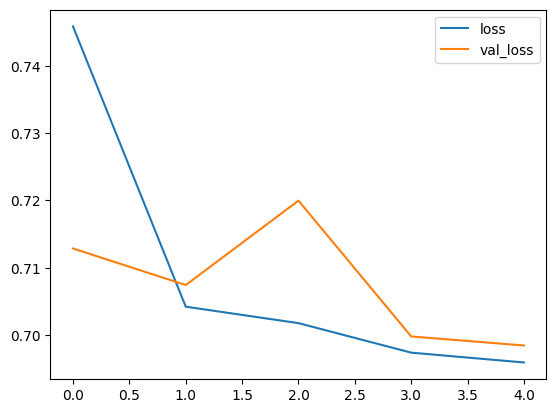

In [18]:
history_frame = pandas.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [26]:
data = pandas.read_csv('/Users/akshitshishodia/intern/tracker/labels_my-project-name_2023-06-27-09-45-54.csv')
data.head()
# for file in os.listdir(path='/Users/akshitshishodia/intern/tracker/dataset'):
#     display(file)
img = cv2.imread('/Users/akshitshishodia/intern/tracker/dataset/frame540.jpg')
row = data[data['image_name']=='frame540.jpg']
x_min = int(row.bbox_x)
y_max = int(row.bbox_y)
x_max= int(row.bbox_x)+int(row.bbox_width)
y_min = int(row.bbox_y)+int(row.bbox_height)
img = cv2.rectangle(img,(x_min,y_min),(x_max,y_max),(0,255,0),5)
cv2.imshow('frame',img)
cv2.waitKey(0)
cv2.destroyAllWindows()
# s = int(i.bbox_height)
# data.head()

In [26]:
img = cv2.imread('/Users/akshitshishodia/intern/tracker/refined/gripper/1.png')
img = img_to_array(img)
img = preprocess_input(img)
img = cv2.resize(img,(224,224))
img = numpy.expand_dims(img,axis=0)

model.predict(img)

1/1 [==============================] - 1s 1s/step


array([[0.38426402, 0.615736  ]], dtype=float32)

In [27]:
import tensorflow

model = tensorflow.keras.models.load_model('/Users/akshitshishodia/intern/tracker/model_3.h5')
lb = pickle.loads(open('/Users/akshitshishodia/intern/tracker/label_encoder.pickle','rb').read())


LabelBinarizer()